# Benchmark: Area computation

Benchmark comparing area computation across:
* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_area-- --out-file ../analysis/benchmark_area/data.json  --iterations 1000
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
        duration.total_ms             
program               geo         geos
count         1000.000000  1000.000000
mean             2.303236     6.598429
std              1.352202     3.218631
min              1.778028     5.651793
25%              1.861961     5.777375
50%              2.116806     5.923583
75%              2.258951     6.200262
max             22.064592    59.005650


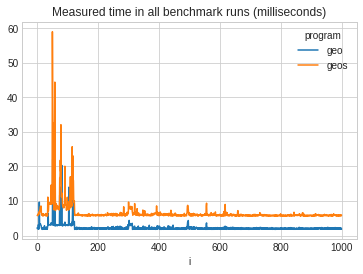

### Statistics: After outlier removal
        duration.total_ms            
program               geo        geos
count          974.000000  974.000000
mean             2.159600    6.205512
std              0.394523    0.871470
min              1.778028    5.651793
25%              1.860349    5.771224
50%              2.112620    5.915539
75%              2.233050    6.159047
max              4.384664   12.219989


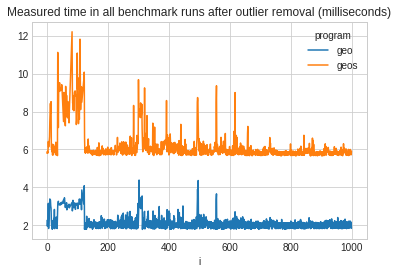

## Absolute difference in runtimes compared to geo
        difference_ms
program          geos
count      974.000000
mean         4.045912
std          0.680307
min          2.695095
25%          3.581699
50%          4.004618
75%          4.209197
max          9.015732


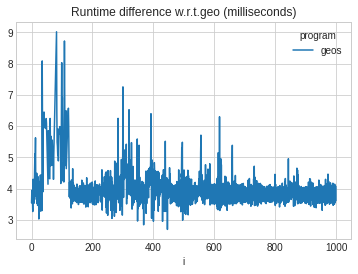

## Relative difference (percent) in runtimes compared to geo
        relative_difference_percent
program                        geos
count                    974.000000
mean                     191.577938
std                       37.534478
min                       68.566237
25%                      163.793053
50%                      186.157376
75%                      222.617900
max                      309.610721


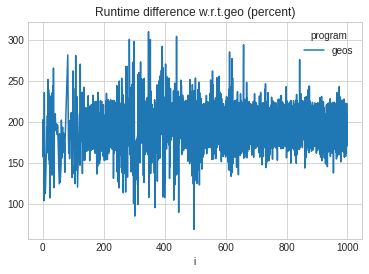

In [6]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb